In [663]:
import pandas as pd
from sklearn.decomposition import PCA
from sktime.datatypes import convert_to
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

def _removeNaNs(df:pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if df[col].isna().any():
            df = df.drop(col, axis=1)
    return df

def _remove_monotonically_increasing_rows(df_list:list) -> list:
    x:pd.DataFrame
    returnlist = []
    for x in df_list:
        dropme = []
        for column in x.columns:
            if x[column].is_monotonic_increasing or x[column].is_monotonic_decreasing:
                dropme.append(column)
        returnlist.append(x.drop(dropme,axis=1))
    return returnlist

def remove_non_ubiquitous(frames:list) -> list:
    template:pd.DataFrame = frames[0]
    #Round 1: Reduces the first frame to be the smallest size to match with everyone
    for frame in frames[1:]:
        common_columns = template.columns.intersection(frame.columns)
        template = template.reindex(columns=common_columns)
    returnlist = [template]
    #Round 2: Reduces all the other ones to the same minimum
    for frame in frames[1:]:
        common_columns = template.columns.intersection(frame.columns)
        returnlist.append(frame.reindex(columns=common_columns))
    return returnlist

def _make_datetime_index(timestamps:list) -> pd.DatetimeIndex:
    beginning = timestamps[0]
    end = timestamps[-1]
    beginning, end = pd.to_datetime((beginning,end), unit="s")
    index = pd.date_range(start=beginning, end=end, periods=len(timestamps))
    return index

def impute_nans(df:pd.DataFrame):
    #Prior testing revealed optimal KNN imputation
    imputer = KNNImputer(n_neighbors=1)
    complete_value_set = imputer.fit_transform(df)
    imputed_df = pd.DataFrame(complete_value_set, index=df.index, columns=df.columns)
    return imputed_df

def _readcsv_modified(csv_loc:str) ->pd.DataFrame:
    csv:pd.DataFrame
    try:
        csv = pd.read_csv(csv_loc, skip_blank_lines=True)   
    except pd.errors.ParserError:
        return
    except pd.errors.EmptyDataError:
        print(csv_loc)
        return
    metrics = csv["identifier"].to_list()
    timestamps = csv.columns[1:].to_flat_index()
    timestamps = timestamps.to_numpy().tolist()
    timestamps = _make_datetime_index(timestamps)
   # index = pd.MultiIndex.from_product([[num], timestamps], names=['instances','timepoints'])
    vals = csv.drop(labels="identifier",axis=1).to_numpy().transpose()
    s = pd.DataFrame(vals, index=timestamps, columns=metrics)
    return s

def reduce_NaNs(df:pd.DataFrame, treshold:int):
    #Calculate the percent of NaNs in each columns (corresponds to feature in the time series)
    length = len(df)
    nan_counts = df.isna().sum()
    nan_percentages = (nan_counts / length) * 100
    #Put it neatly into a dataframe 
    percentdf = pd.DataFrame({'Column':nan_percentages.index,'nan_percent':nan_percentages.values })
    #Create a boolean mask that corresponds to NaN percent being under the treshold (True=good)
    removal_mask = percentdf["nan_percent"] < treshold
    #trim the dataframe to only include only truthy values
    percentdf = percentdf.loc[removal_mask]
    #Get the names of the columns that pass
    okay_cols = percentdf["Column"]
    #Return a trimmed dataframe with only the listed columns
    return df[okay_cols]

def scaledf(df:pd.DataFrame) -> pd.DataFrame:
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(df), index=df.index, columns= df.columns)

def perform_pca(df:pd.DataFrame, pca_components) -> pd.DataFrame:
    pca_scaler = PCA(n_components = pca_components)
    scaled = pca_scaler.fit_transform(df)
    return pd.DataFrame(scaled, index=df.index)

def readcsvs(csv_loc_list:list, remove_monotonic_increasing=True, reduce_NaNs_treshold=50, remove_unique_cols=True, scale=True, pca_components=0, impute=False):
    individual_dataframes = []
    for i in range(len(csv_loc_list)):
        df = _readcsv_modified(csv_loc_list[i])
        #The read_csv pandas function sometimes fails when something went wrong with the metric collection from prometheus. These are simply skipped without throwing errors
        if df is not None:
            individual_dataframes.append(df) #time series
        else:
            print(i)

    if remove_monotonic_increasing:
        individual_dataframes = _remove_monotonically_increasing_rows(individual_dataframes)
    #Here: Go through the loop once again, start trimming. compare everything to element at 0, trim with it so it stays as the leanest version.

    if remove_unique_cols:
        individual_dataframes = remove_non_ubiquitous(individual_dataframes)

    concated = convert_to(individual_dataframes,to_type='pd-multiindex' )
    #NaNs can appear when concating dfs so this is done after the conversion to multiindex df
    if reduce_NaNs_treshold:
        concated = reduce_NaNs(concated, reduce_NaNs_treshold)
    
    if impute:
        concated = impute_nans(concated)

    if scale:
        concated = scaledf(concated)

    if pca_components != 0:
        concated = perform_pca(concated, pca_components)

    return concated


from get_all_metrics_with_tags import get_all_metrics_with_tags 
df = readcsvs(get_all_metrics_with_tags("/home/magnus/Documents/thesis-project/query/automated/generated_csvs_4")[0], pca_components=10, remove_unique_cols=False, impute=True)
dfcopy = df.copy(True)
df


/tmp/ipykernel_11519/825769137.py:40: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  beginning, end = pd.to_datetime((beginning,end), unit="s")
/tmp/ipykernel_11519/825769137.py:40: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  beginning, end = pd.to_datetime((beginning,end), unit="s")
/tmp/ipykernel_11519/825769137.py:40: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matc

0         1         2  \
instances timepoints                                                    
0         2023-04-28 04:37:20.000000000  2.597091 -2.487014 -1.875056   
          2023-04-28 04:37:24.848484848  1.998505 -1.609742 -1.056261   
          2023-04-28 04:37:29.696969696  1.755072 -0.981373 -3.103763   
          2023-04-28 04:37:34.545454545  2.621458 -2.667594 -3.049499   
          2023-04-28 04:37:39.393939393  2.597433 -0.843648 -0.394681   
...                                           ...       ...       ...   
177       2023-04-28 07:31:56.606060606  0.662769 -2.106751 -0.901812   
          2023-04-28 07:32:01.454545454  0.662769 -2.106751 -0.901812   
          2023-04-28 07:32:06.303030303  0.662769 -2.106751 -0.901812   
          2023-04-28 07:32:11.151515151  0.662769 -2.106751 -0.901812   
          2023-04-28 07:32:16.000000000  0.662769 -2.106751 -0.901812   

                                                3         4         5  \
instances timepoints                                                    
0         2023-04-28 04:37:20.000000000 -0.724128 -1.129954 -0.172107   
          2023-04-28 04:37:24.848484848 -3.727034 -0.987102  0.183274   
          2023-04-28 04:37:29.696969696  1.630202  0.326817  0.809567   
          2023-04-28 04:37:34.545454545 -1.399369 -1.532932 -0.711449   
          2023-04-28 04:37:39.393939393 -3.244024 -0.664999  0.680446   
...                                           ...       ...       ...   
177       2023-04-28 07:31:56.606060606 -0.604096  2.735235 -0.296701   
          2023-04-28 07:32:01.454545454 -0.604096  2.735235 -0.296701   
          2023-04-28 07:32:06.303030303 -0.604096  2.735235 -0.296701   
          2023-04-28 07:32:11.151515151 -0.604096  2.735235 -0.296701   
          2023-04-28 07:32:16.000000000 -0.604096  2.735235 -0.296701   

                                                6         7         8  \
instances timepoints                                                    
0         2023-04-28 04:37:20.000000000  0.494167 -2.001514 -1.324304   
          2023-04-28 04:37:24.848484848 -0.307131 -2.652210 -1.088198   
          2023-04-28 04:37:29.696969696 -0.053869 -4.112289 -0.816962   
          2023-04-28 04:37:34.545454545 -0.201631 -2.314112 -1.487410   
          2023-04-28 04:37:39.393939393  0.693800 -3.570014 -0.476082   
...                                           ...       ...       ...   
177       2023-04-28 07:31:56.606060606 -0.950459 -0.149236 -2.227411   
          2023-04-28 07:32:01.454545454 -0.950459 -0.149236 -2.227411   
          2023-04-28 07:32:06.303030303 -0.950459 -0.149236 -2.227411   
          2023-04-28 07:32:11.151515151 -0.950459 -0.149236 -2.227411   
          2023-04-28 07:32:16.000000000 -0.950459 -0.149236 -2.227411   

                                                9  
instances timepoints                               
0         2023-04-28 04:37:20.000000000  2.375843  
          2023-04-28 04:37:24.848484848  2.140879  
          2023-04-28 04:37:29.696969696  1.133989  
          2023-04-28 04:37:34.545454545  2.214046  
          2023-04-28 04:37:39.393939393  1.632797  
...                                           ...  
177       2023-04-28 07:31:56.606060606  0.718359  
          2023-04-28 07:32:01.454545454  0.718359  
          2023-04-28 07:32:06.303030303  0.718359  
          2023-04-28 07:32:11.151515151  0.718359  
          2023-04-28 07:32:16.000000000  0.718359  

[23674 rows x 10 columns]

In [664]:
df = dfcopy.copy(True)
print(df.shape)
def calculate_variance(df:pd.DataFrame) ->pd.Series:
    #The coefficient of variation
    cv = df.std() / df.mean()
    return cv.round(10).sort_values(ascending=False)
def select_by_variance(df:pd.DataFrame, amount:int):
    variances:pd.Series = calculate_variance(df)
    selection = variances.iloc[0:amount]
    return selection

(23674, 10)


In [665]:
best_features = select_by_variance(df, 5)
fivebest = df[best_features.index.to_series()]


In [666]:
import seaborn as sns
import matplotlib.pyplot as plt
y = ["carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users"]


In [667]:
def annotate_label(df, labels):
    df["label"] = 0
    for idx, row in fivebest.iterrows():
        indexvalue= idx[0]
        df.at[idx, "label"] = labels[indexvalue]


In [668]:
for idx, row in fivebest.iterrows():
    indexvalue = idx[0]
    fivebest.at[idx, "label"] = y[indexvalue]


/tmp/ipykernel_11519/482621391.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fivebest.at[idx, "label"] = y[indexvalue]
/tmp/ipykernel_11519/482621391.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'carts' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  fivebest.at[idx, "label"] = y[indexvalue]


In [669]:
def reindex_timepoints(df):
    grouped_by_instances = df.groupby("instances")
    level0 = df.index.get_level_values(0)
    level1 = grouped_by_instances.cumcount().values
    newindex = pd.MultiIndex.from_arrays([level0, level1], names=["instances", "timepoints"])
    df.index = newindex
    return df
    

In [670]:
def meanvalues(names, df:pd.DataFrame):
    frames = []
    grouped = df.groupby("label")
    for name in names:
        newdf = grouped.get_group(name).drop("label",axis=1)
        reindexed = reindex_timepoints(newdf)
        means = reindexed.groupby("timepoints").mean()
        means["label"] = name
        frames.append(means)
    return frames

In [671]:
meansdfs = meanvalues(["carts","even_load","catalog","users","idle"], fivebest)

In [672]:
# import time
# import numpy as np
# times = []
# for i in range(10):
#     timea = time.process_time()
#     df = readcsvs(get_all_metrics_with_tags("/home/magnus/Documents/thesis-project/query/automated/generated_csvs_4")[0], pca_components=0, remove_unique_cols=True, impute=False)
#     timeb = time.process_time()
#     times.append(timeb-timea)
# print(np.mean(times))

In [673]:
useful_metrics = ["nodejs_eventloop_lag_seconds&edge-router:80&frontend","go_memstats_heap_alloc_bytes&catalogue:80&catalogue", "go_memstats_stack_inuse_bytes&user:80&user"]

In [674]:
combined_df = pd.concat(meansdfs)
combined_df

,4,0,9,1,2,label
timepoints,,,,,,
0,0.172650,0.879153,0.613552,-0.087383,-0.805444,carts
1,0.230528,0.630736,0.471429,0.328037,-0.515379,carts
2,0.546531,1.049060,0.320869,0.309178,-0.576624,carts
3,0.356754,0.909067,0.234916,0.360037,-1.186534,carts
4,0.102786,1.021225,0.318433,0.518515,-0.486012,carts
...,...,...,...,...,...,...
128,0.223464,-0.881881,-0.623265,-0.470670,0.371253,idle
129,0.563686,-0.859130,-0.782797,-0.453507,-0.009920,idle
130,0.297309,-0.941573,-0.663376,-0.416411,0.196750,idle


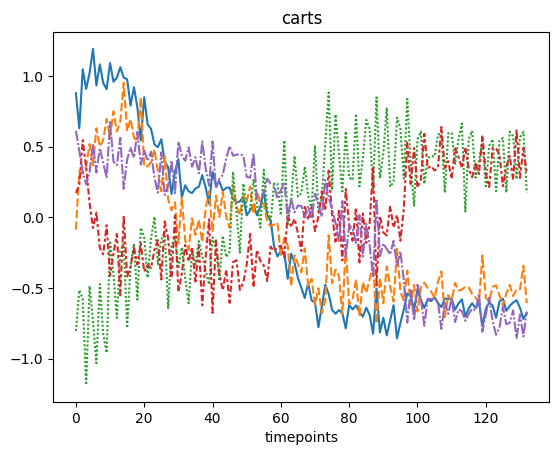

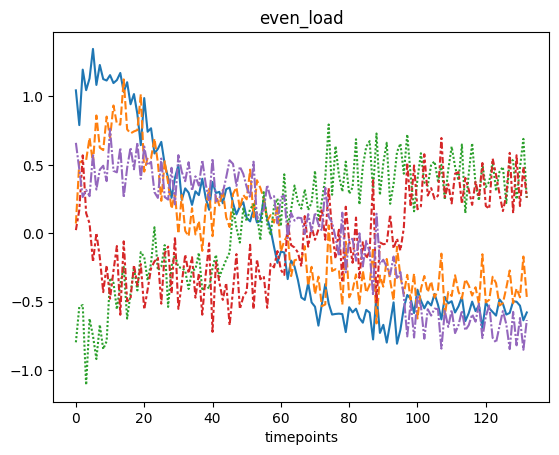

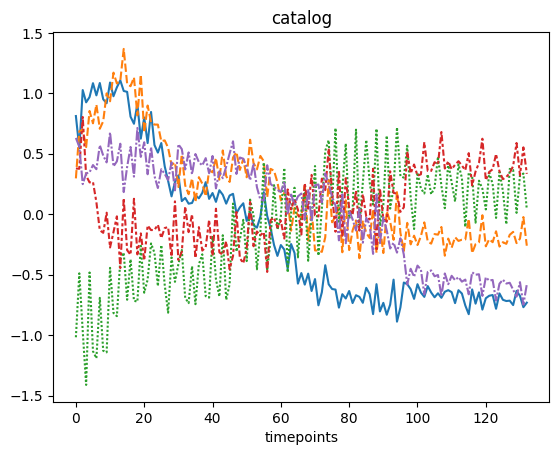

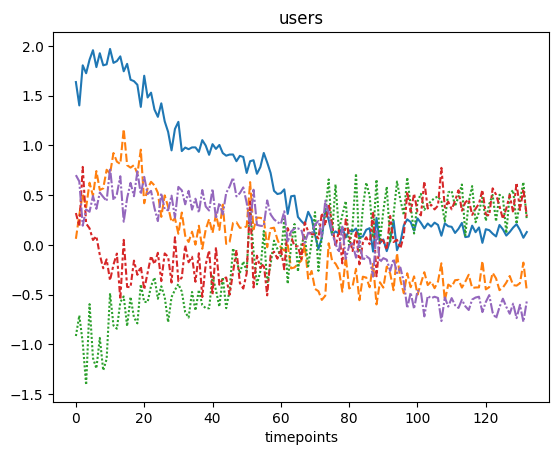

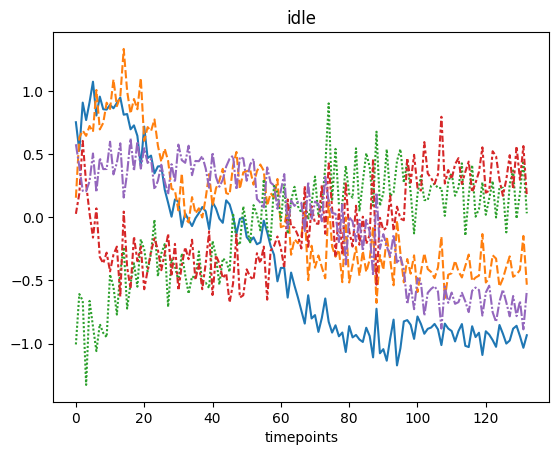

In [681]:
for df in meansdfs:
    axes = sns.lineplot(df)
    axes.set(title=df["label"][0])
  #  axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    axes.legend().remove()
    # print(axes)
    # for ax in axes:
    #     ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    #     print(ax)
    plt.show()


In [676]:
df_read = pd.read_csv("Imputed_and_reduced_noremove.csv")
df_read["instances"]

0          0
1          0
2          0
3          0
4          0
        ... 
23669    177
23670    177
23671    177
23672    177
23673    177
Name: instances, Length: 23674, dtype: int64

In [677]:
def get_nan_percents(df:pd.DataFrame):
    #Calculate the percent of NaNs in each columns (corresponds to feature in the time series)
    length = len(df)
    nan_counts = df.isna().sum()
    nan_percentages = (nan_counts / length) * 100
    percentdf = pd.DataFrame({'Column':nan_percentages.index,'nan_percent':nan_percentages.values })
    
    return percentdf #.sort_values(by='nan_percent').reset_index(drop=True)
nandf = get_nan_percents(df)

In [678]:
import seaborn as sns
import matplotlib.pyplot as plt
# sns.displot(data=nandf)
# plt.xlabel('NaN percentage')
# plt.ylabel("Amount of features")
# plt.title('NaN Distribution')
# plt.show()

# total_average_nans = nandf["nan_percent"].sum() / len(nandf)
# print("Total NaN percent: ", total_average_nans)


In [679]:
def remove_nans_treshold(df:pd.DataFrame, treshold=70):
    #Create a mask of all columns(features) that have a very high NaN percent, and drop them. This is to make imputing more reliable. Might need to tune/revisit the idea later.
    percentdf = get_nan_percents(df)
    remove_mask = percentdf["nan_percent"] < treshold
    percentdf = percentdf.loc[remove_mask]
    okay_cols = percentdf["Column"]
    return df[okay_cols]
print(nandf.iloc[0]['nan_percent'],nandf.iloc[-1]["nan_percent"])
trimmed_df = remove_nans_treshold(df)
trimmed_df

0.0 0.0


,4,0,9,1,2,label
timepoints,,,,,,
0,0.027750,0.753457,0.579232,0.155173,-1.006823,idle
1,0.188791,0.527671,0.403491,0.631793,-0.607952,idle
2,0.605525,0.908905,0.209469,0.687585,-0.659903,idle
3,0.264786,0.770493,0.206945,0.645591,-1.327608,idle
4,0.032109,0.911705,0.285965,0.723468,-0.662049,idle
...,...,...,...,...,...,...
128,0.223464,-0.881881,-0.623265,-0.470670,0.371253,idle
129,0.563686,-0.859130,-0.782797,-0.453507,-0.009920,idle
130,0.297309,-0.941573,-0.663376,-0.416411,0.196750,idle


In [680]:
#Imputation
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
knn_imputed = imputer.fit_transform(trimmed_df)


TypeError: Feature names are only supported if all input features have string names, but your input has ['int', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

In [ ]:
knn_imputed_df = pd.DataFrame(knn_imputed, columns=trimmed_df.columns, index=trimmed_df.index)

In [ ]:
from sktime.classification.kernel_based import RocketClassifier
y = ["carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "carts", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "catalog", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "even_load", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "idle", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users", "users"]

In [ ]:
dflist = convert_to(df, to_type="df-list")

In [ ]:
classifier = RocketClassifier()
import numpy as np

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(dflist, y)

In [ ]:
classifier.fit(X_train, np.array(y_train))

In [ ]:
classifier.score(X_test, np.array(y_test))

In [ ]:
imputed_and_reduced = pd.read_csv("Imputed_and_reduced_noremove.csv")
imputed_and_reduced.loc[0]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(imputed_and_reduced, y)